# **Final Project ML for Time Series**

### **Subject**: *A Symbolic Representation of Time Series, with Implications for Streaming Algorithms*, Jessica Lin, Eamonn Keogh, Stefano Lonardi, Bill Chiu

#### **Authors**: Tom Rossa and Naïl Khelifa

## **Table of Contents**  
1. [Introduction](#introduction)  
2. [Data Exploration](#data-exploration)  
   - [Importing Libraries and Data](#importing-libraries-and-data)  
   - [Data Overview](#data-overview)  
   - [Descriptive Statistics and Data Visualization](#statistics-and-visualization)    
3. [Data Preprocessing](#data-preprocessing)  
   - [Normalisation - Why Does It Matters?](#Normalisation)  
4. [(SAX-based) Symbolization Methods Review and Reconstruction](#reconstruction)  
   - [SAX](#SAX)  
   - [ESAX](#EAX)  
   - [TSAX](#TSAX) 
   - [1D-SAX](#1D-SAX) 
   - [ASTRIDE](#ASTRIDE) 
   - [Reconstruction Conclusion](#conclusion-reconstruction)  
5. [Classification](#classification)  
   - [Nearest Neighbors Classification](#neighbor)  
   - [Sensitivity to Parameters](#other)  
   - [Classification Conclusion](#conclusion-classification)  
6. [Clustering](#clustering)  
   - [Partitional Clustering](#partitional)  
   - [Sensitivity to Parameters](#other)  
   - [Clustering Conclusion](#conclusion-clustering)  
8. [Conclusion and Perspectives](#conclusion-and-perspectives)

# **Introduction**

The goal of this project is to replicate and extend the experiments presented in the paper *A Symbolic Representation of Time Series, with Implications for Streaming Algorithms* (Lin et al.).

---

## **Different Approaches to Symbolization**

This project is based on the paper *A Symbolic Representation of Time Series, with Implications for Streaming Algorithms* (Lin et al.). The age of the proposed method and the diversity of the variants of the Symbolic Aggregate approXimation (SAX) method introduced in this paper led us to compare these different methods and observe their strengths and weaknesses depending on the type of data (classification with few or many classes, symbolization of longer or shorter time series, clustering, etc.). As part of this project, we will compare different methods for symbolizing time series.  

There is extensive literature on this subject, and numerous methods—each more inventive than the last—have emerged. Symbolization involves transforming a time series of size $N$, whose values evolve in a continuous space (often $\mathbb{R}$ for univariate series), into a "word" of size $k << N$ formed from a finite alphabet of size $A$. The aim of this process is to massively reduce the storage space occupied by a symbolized time series while losing as little information as possible about the series. Various approaches to symbolization exist, each with advantages and disadvantages, which we will compare for tasks such as classification, clustering, and indexing. To ensure fair comparison, we will evaluate how well each method performs for these tasks with a given alphabet size and word length.  

The methods we study are as follows:  
- SAX (Symbolic Aggregate approXimation)  
- ESAX (Extended SAX)  
- TSAX (Trend SAX)  
- 1D-SAX (One-Dimensional SAX)  
- ASTRIDE (Adaptive Symbolic Time-series Representation for Indexing and DEnsity estimation)  
- SFA (Symbolic Fourier Approximation)  
- BOSS (Bag of SFA Symbols) 

# **Data Exploration**

## **Importing Librairies and Data**

### Librairies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from dtw import dtw
import os
from scipy import signal
import seaborn as sns
from statsmodels.tsa.stattools import acf

##Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

## TSLEARN
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset

## Custom : code implémenté par nous-même
from Symbol import SYMBOLS
from SFA import *
from ASTRIDE import *
from SAX_transf import *
from distances import MINDIST, TRENDIST
import utils
import warnings 

warnings.filterwarnings('ignore')


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Data

In [2]:
ECG200_X_train, ECG200_x_train, ECG200_y_train, ECG200_X_test, ECG200_x_test, ECG200_y_test = utils.generate_data(type="ECG200")
acsf1_X_train, acsf1_x_train, acsf1_y_train, acsf1_X_test, acsf1_x_test, acsf1_y_test = utils.generate_data(type="acsf1")
catsanddogs_X_train, catsanddogs_x_train, catsanddogs_y_train, catsanddogs_X_test, catsanddogs_x_test, catsanddogs_y_test = utils.generate_data(type="catsanddogs")

## **Data Overview**

In this work, we will consider three databases, each containing a specific structure that we will attempt to leverage to illustrate the differences between the various methods. A brief description of these databases is provided below:

### *1. ECG200 Dataset*

**Data Source:** [Link](https://timeseriesclassification.com/description.php?Dataset=ECG200)

**Donated By:** R. Olszewski  

**Description:**  
This dataset was formatted by R. Olszewski as part of his thesis *"Generalized feature extraction for structural pattern recognition in time-series data"* at Carnegie Mellon University, 2001. Each series traces the electrical activity recorded during one heartbeat. The two classes are:
- **Normal heartbeat**  
- **Myocardial Infarction**  


#### Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type** |
|-----------------|--------------|------------|------------------------|--------------------------|----------|
| 100             | 100          | 96         | 2                      | 1                        | ECG      |


### *2. ACSF1 Dataset*

**Data Source:** [Link](https://timeseriesclassification.com/description.php?Dataset=ACSF1)  
**Donated By:** P. Schafer

**Description:**  
The dataset is compiled from **ACS-F1**, the first version of the database of appliance consumption signatures. The dataset contains the power consumption of typical appliances. The recordings are characterized by long idle periods and some high bursts of energy consumption when the appliance is active.

The classes correspond to **10 categories of home appliances**:
- Mobile phones (via chargers)
- Coffee machines
- Computer stations (including monitor)
- Fridges and freezers
- Hi-Fi systems (CD players)
- Lamp (CFL)
- Laptops (via chargers)
- Microwave ovens
- Printers
- Televisions (LCD or LED)

There is nothing to infer from the order of examples in the train and test set.

Data created by **Gisler, Christophe, et al. [1]** and ([Link Here](https://icosys.ch/acs-f1))  
Data edited by **Patrick Schafer and Ulf Leser** (see [2]).

### References
1. Gisler, Christophe, et al. *"Appliance consumption signature database and recognition test protocols."* Systems, Signal Processing and their Applications (WoSSPA), 2013 8th International Workshop on. IEEE, 2013.
2. Schafer, Patrick, and Ulf Leser. *"Fast and accurate time series classification with WEASEL."* Proceedings of the 2017 ACM on Conference on Information and Knowledge Management. ACM, 2017.

#### Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type**  |
|------------|-----------|--------|--------------------|-----------------------|-------|
| 100        | 100       | 1460    | 10                 | 1                     | DEVICE |

### *3. Cats and Dogs Dataset*

**Data Source:** [Link](https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs)  
**Donated By:** Naoya Takahashi, Michael Gygli, Beat Pfister and Luc Van Gool

**Description:**  
This dataset is aimed to be the audio counterpart of the famous "cats and dogs" image classification task, here available on Kaggle.

Content
The dataset consists in many "wav" files for both the cat and dog classes :

cat has 164 WAV files to which corresponds 1323 sec of audio
dog has 113 WAV files to which corresponds 598 sec of audio

The data is very sinusoidal.

#### References
*Deep Convolutional Neural Networks and Data Augmentation for Acoustic Event Recognition*, Proc. Interspeech 2016, San Fransisco.

#### Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type**  |
|------------|-----------|--------|--------------------|-----------------------|-------|
| 138        | 137       | 14773    | 2                 | 1                     | AUDIO |



In this work, the idea is to leverage the specific characteristics of each dataset:

1. **ECG200**:  
   This dataset consists of relatively short time series with a small number of classes. It is well-suited for evaluating methods that focus on compact representation and efficient classification.  

3. **ACSF1**:  
   This dataset is composed of very long time series with ten classes. It provides a challenging scenario for methods that must balance information compression with the ability to distinguish between numerous categories.  

2. **Cats and Dogs**:  
   This dataset contains very long time series with a small number of classes. It allows us to analyze how the methods perform on larger time series while maintaining classification accuracy. It provides an extension for the Computers dataset.

To further justify the choice of these datasets, it is essential to visualize them.

## **Descriptive Statistics and Data Visualization**

In this section:

1. **Description of Time Series Characteristics in Each Dataset**  
   We begin by briefly describing the characteristics of the time series in each of the datasets. This includes their length, number of classes, and the overall nature of the patterns (e.g., trends, periodicity, noise). Understanding these characteristics will help us choose the most appropriate methods for symbolization and identify potential challenges in each dataset.

2. **Visualizing the Average Trend of Each Series and its Distribution Across Classes**  
   Next, we visualize the average trend of each time series and its distribution across different classes. This step is important because we will observe that, often, the difference between a series from one class and a series from another class is due to a small motif or pattern. Some symbolization methods are better at capturing these subtle patterns than others. By visualizing the trends and distributions, we can better understand how each method handles the variations within and between classes, and identify which methods excel at detecting these critical features.

### 1. *ECG200*

In [3]:
utils.describe_ecg_dataset(ECG200_x_train, ECG200_y_train, ECG200_x_test, ECG200_y_test)

Number of examples in the training set: 100
Number of examples in the test set: 100
Length of the time series: 96


Class distribution (Training set):
label
-1    31
 1    69
Name: count, dtype: int64

Class distribution (Test set):
label
-1    36
 1    64
Name: count, dtype: int64




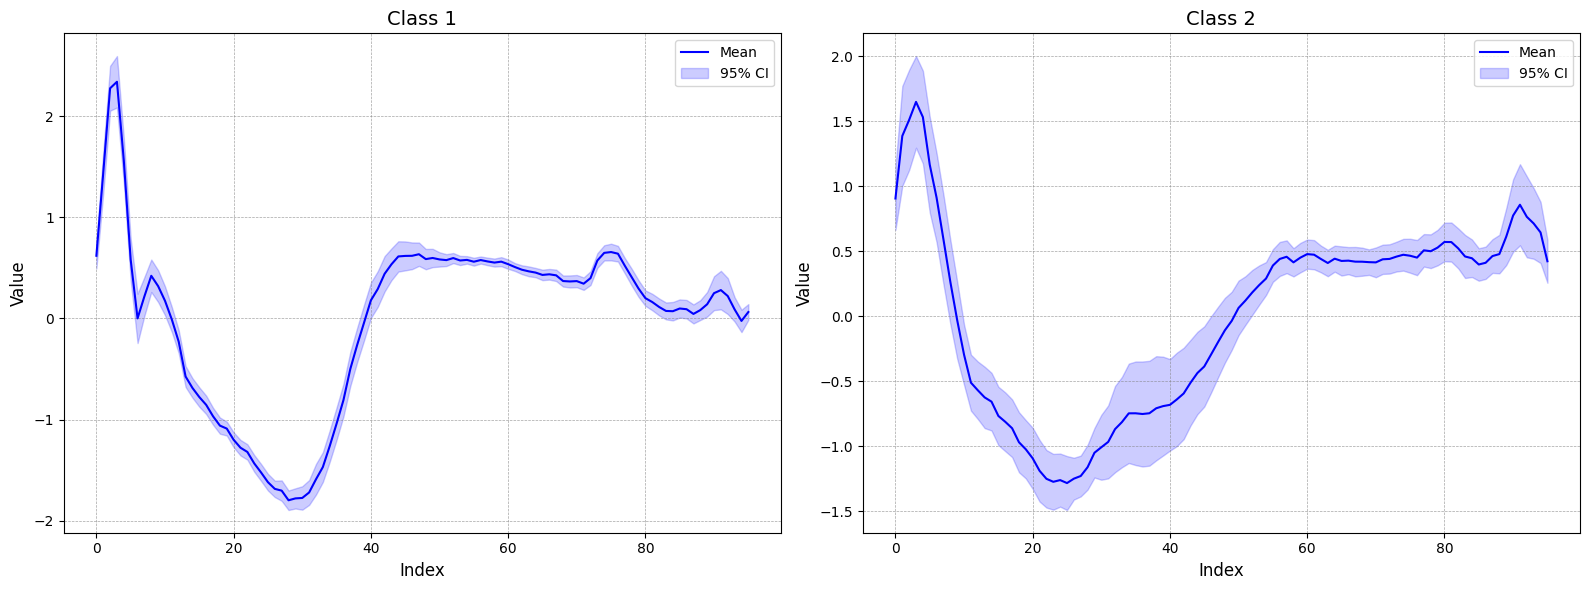

In [4]:
# store the datasets of each class in df_list
df0 = ECG200_X_train[ECG200_X_train["label"]==-1].iloc[:, :-1]
df1 = ECG200_X_train[ECG200_X_train["label"]==1].iloc[:, :-1]
df_list = [df0, df1]

utils.plot_classes(df0, df1, num_seg=None)

Here, we observe a small peak in the downward trend around $t=8$. This is a characteristic of class 1 (which corresponds to an abnormal heart rhythm, Ischemia, in the context of this dataset). As we will see later, this motif will be captured more or less effectively depending on whether the symbolization method encodes the mean, the maximum and minimum values, or the trend within each segment.

Plot the periodogram

Processing dataset 1...
Processing dataset 2...


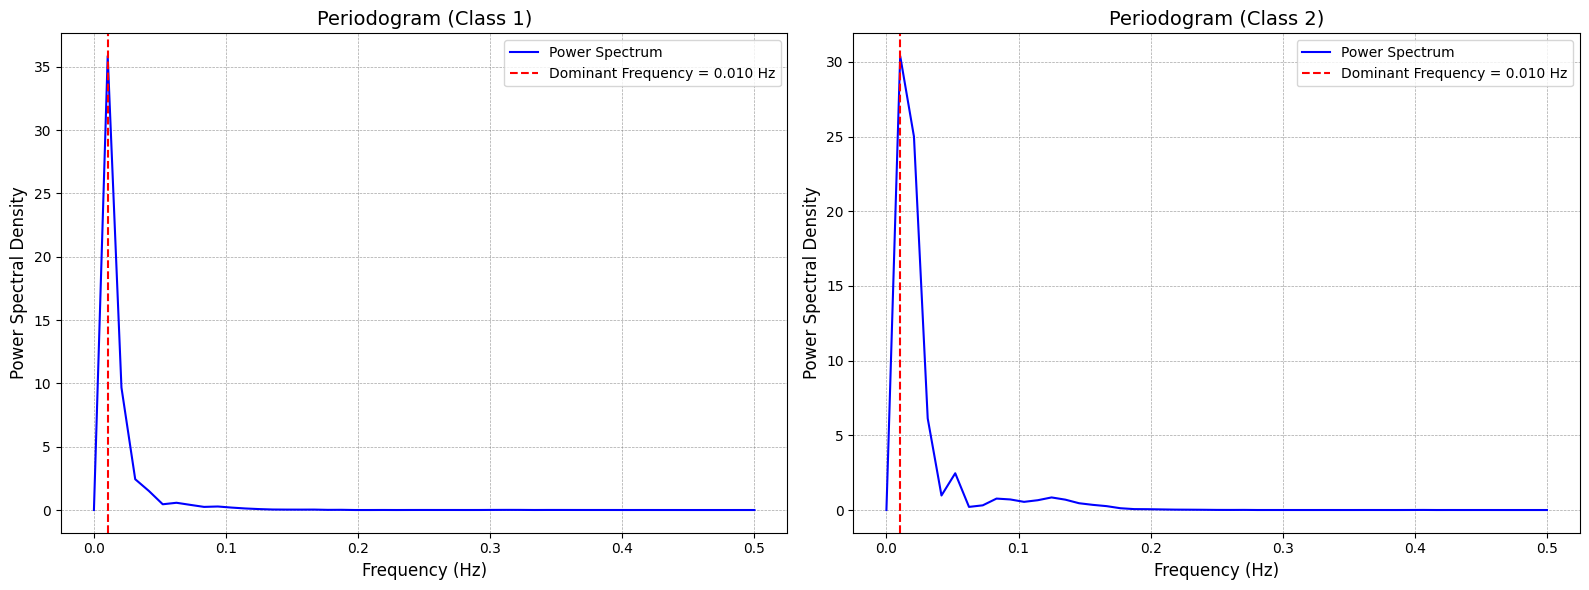

In [5]:
utils.plot_periodogram_mean_series(df_list)

Processing class 1...
Processing class 2...


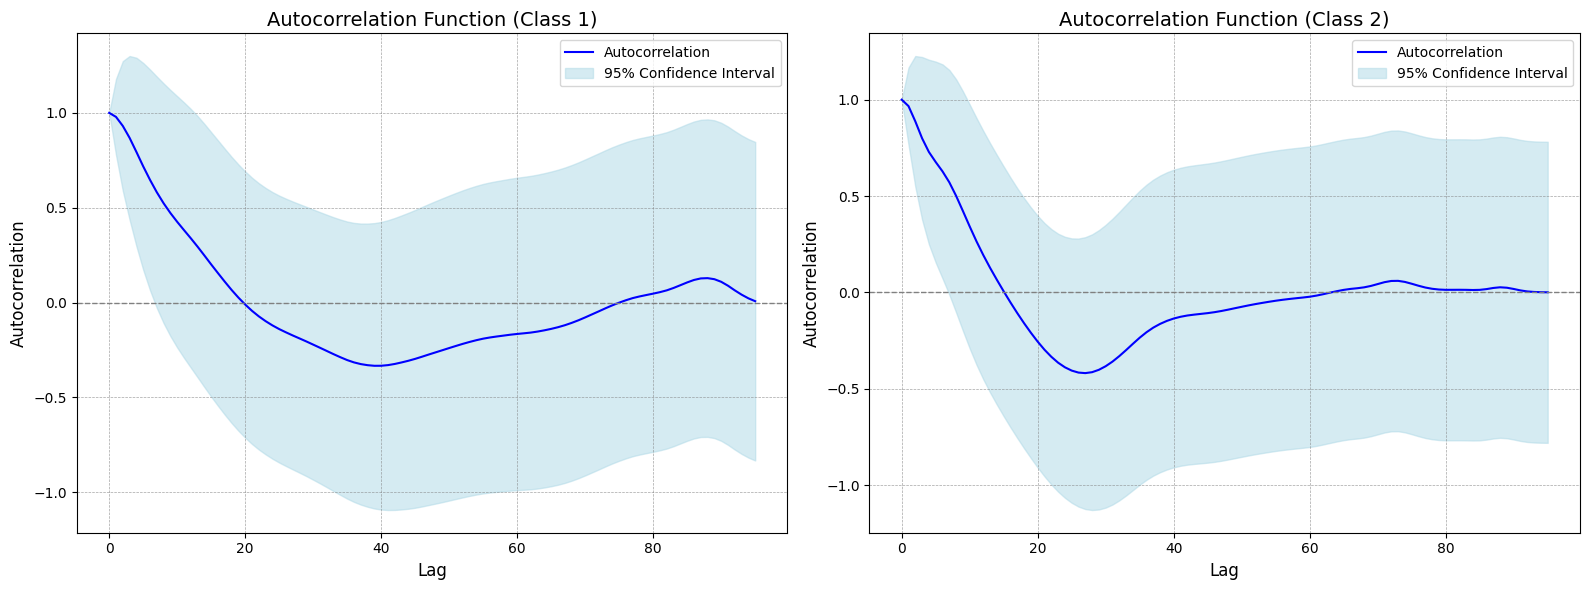

In [6]:
utils.plot_acf_mean_series(df_list)

### *2. ACSF1*

In [7]:
utils.describe_ecg_dataset(acsf1_x_train, acsf1_y_train, acsf1_x_test, acsf1_y_test)

Number of examples in the training set: 100
Number of examples in the test set: 100
Length of the time series: 1460


Class distribution (Training set):
label
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: count, dtype: int64

Class distribution (Test set):
label
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: count, dtype: int64




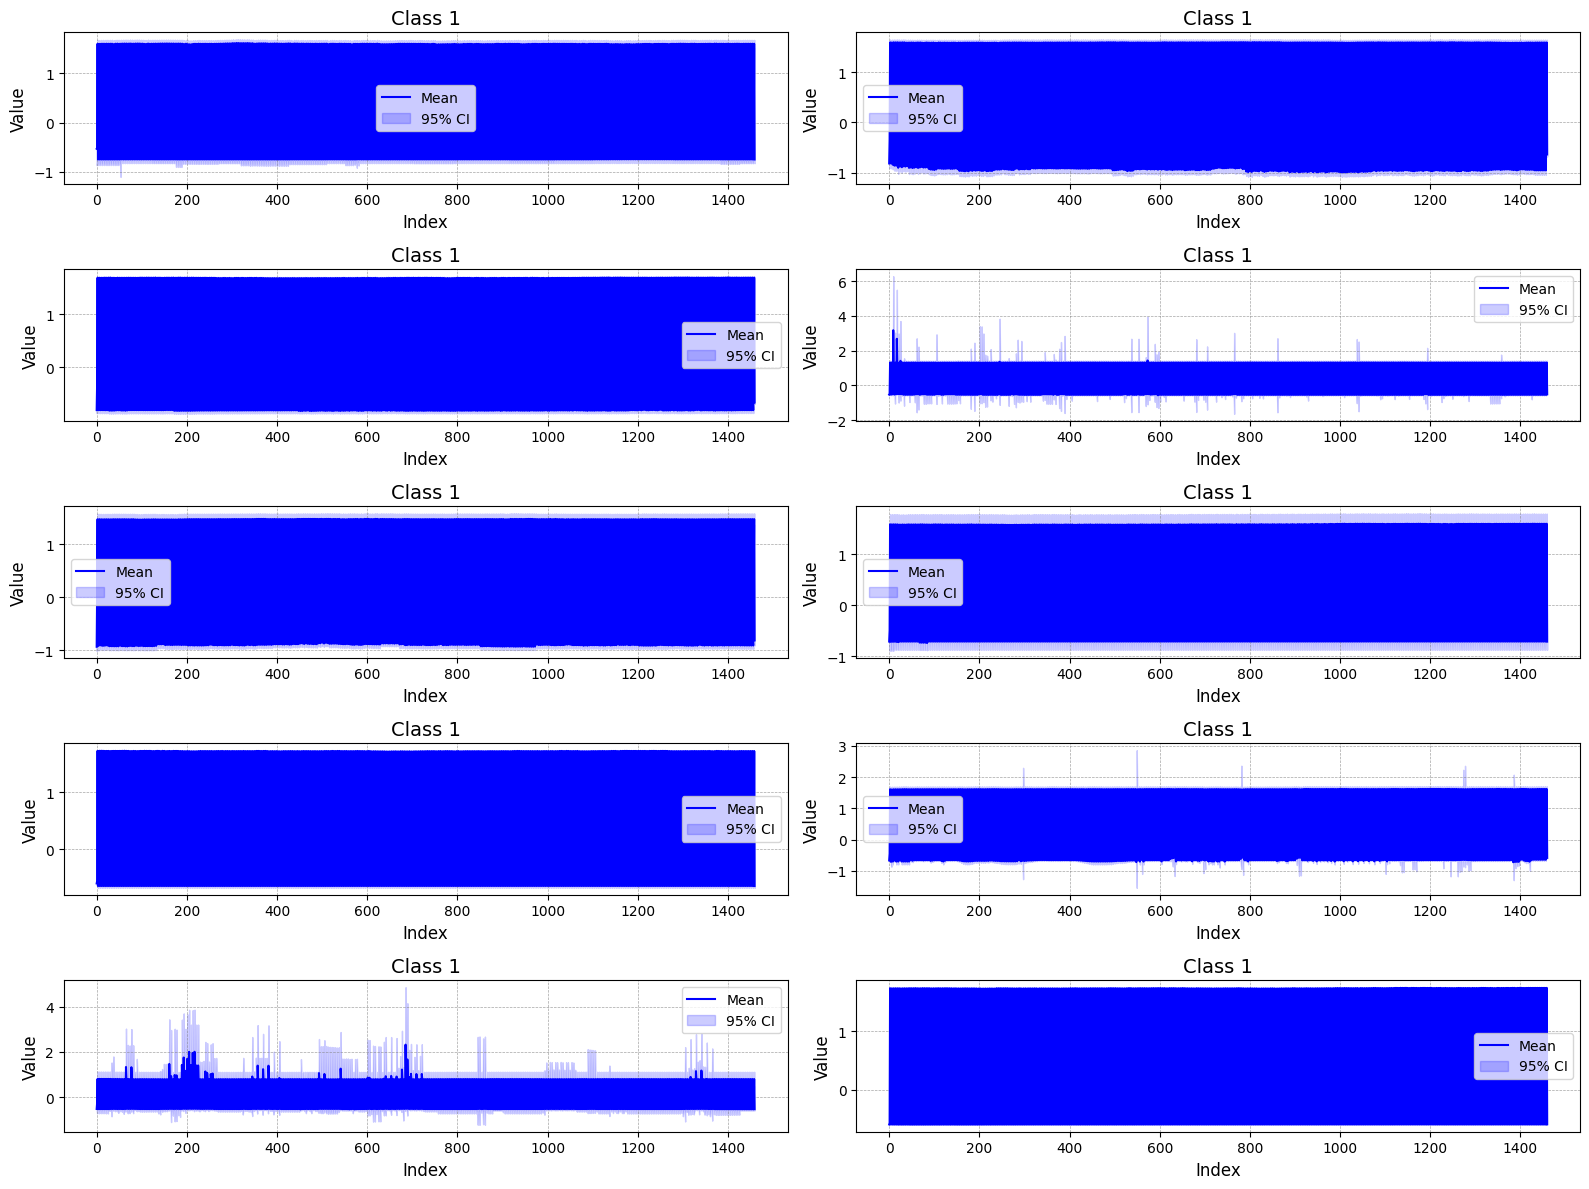

In [8]:
df_list = [acsf1_X_train[acsf1_X_train["label"]==i].iloc[:, :-1] for i in range(10)]
utils.plot_multiple_classes(df_list, num_seg=None)

Similarly, in this dataset, we observe much more noise in class number 2. When looking at the segments obtained by partitioning the x-axis, this noise is primarily represented by much sharper trends rather than by variations in the average values per segment. Here too, we can expect that methods that include trends will perform better than those that only consider the mean values.

Processing class 1...
Processing class 2...
Processing class 3...
Processing class 4...
Processing class 5...
Processing class 6...
Processing class 7...
Processing class 8...
Processing class 9...
Processing class 10...


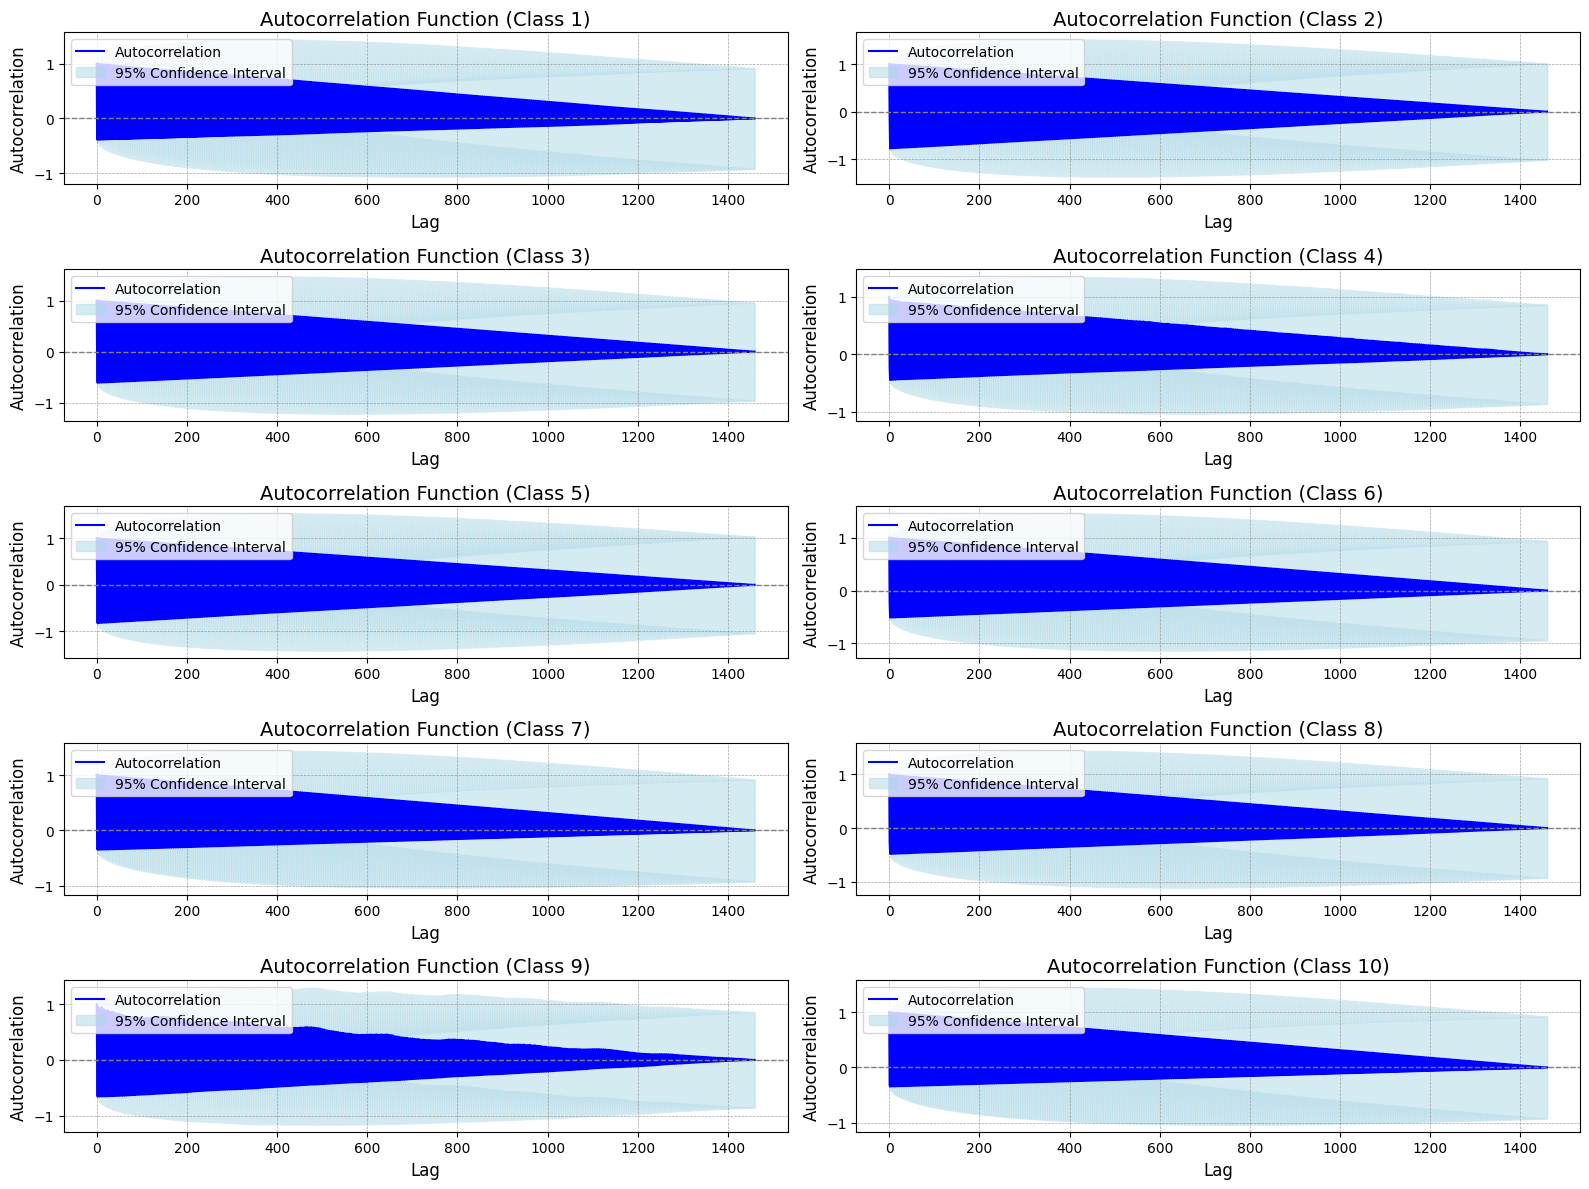

In [9]:
utils.plot_acf_mean_series(df_list, data_type="several_classes")

Processing dataset 1...
Processing dataset 2...
Processing dataset 3...
Processing dataset 4...
Processing dataset 5...
Processing dataset 6...
Processing dataset 7...
Processing dataset 8...
Processing dataset 9...
Processing dataset 10...


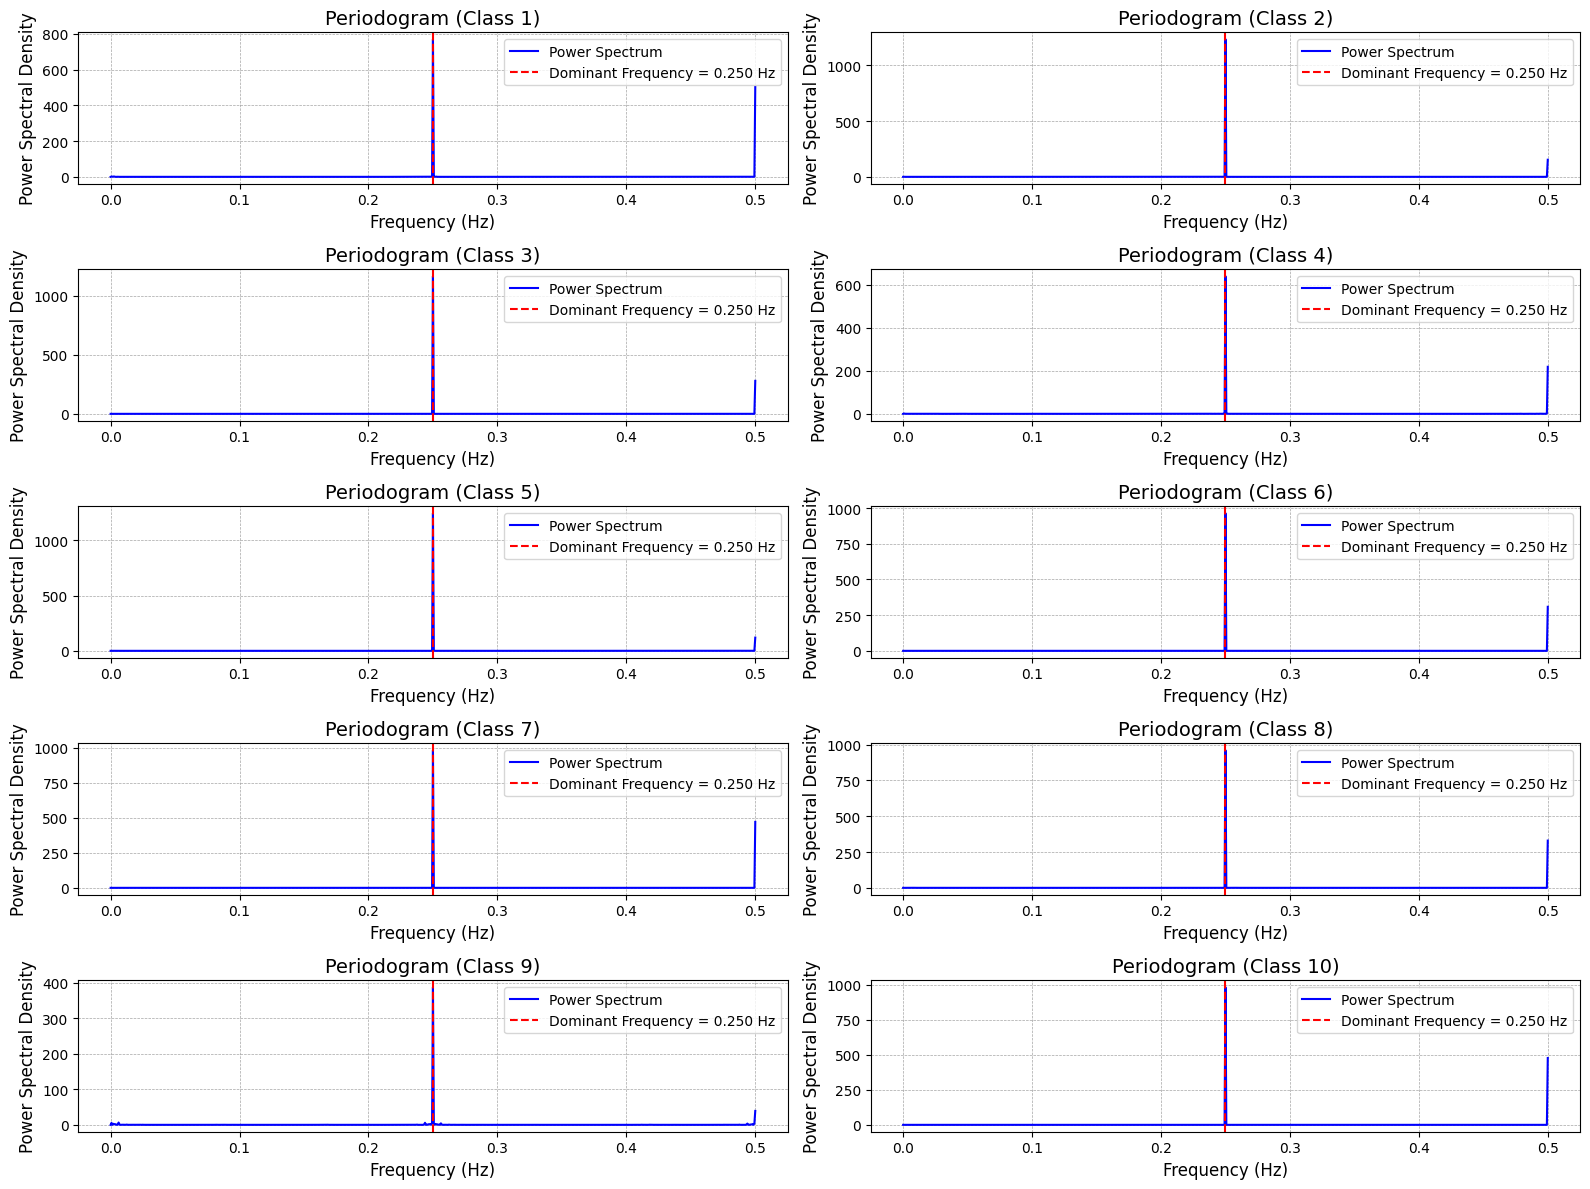

In [10]:
utils.plot_periodogram_mean_series(df_list, data_type="several_classes")

### 3. *Cats and Dogs*

In [11]:
utils.describe_ecg_dataset(catsanddogs_x_train, catsanddogs_y_train, catsanddogs_x_test, catsanddogs_y_test)

Number of examples in the training set: 164
Number of examples in the test set: 164
Length of the time series: 14773


Class distribution (Training set):
label
0    82
1    82
Name: count, dtype: int64

Class distribution (Test set):
label
0    82
1    82
Name: count, dtype: int64




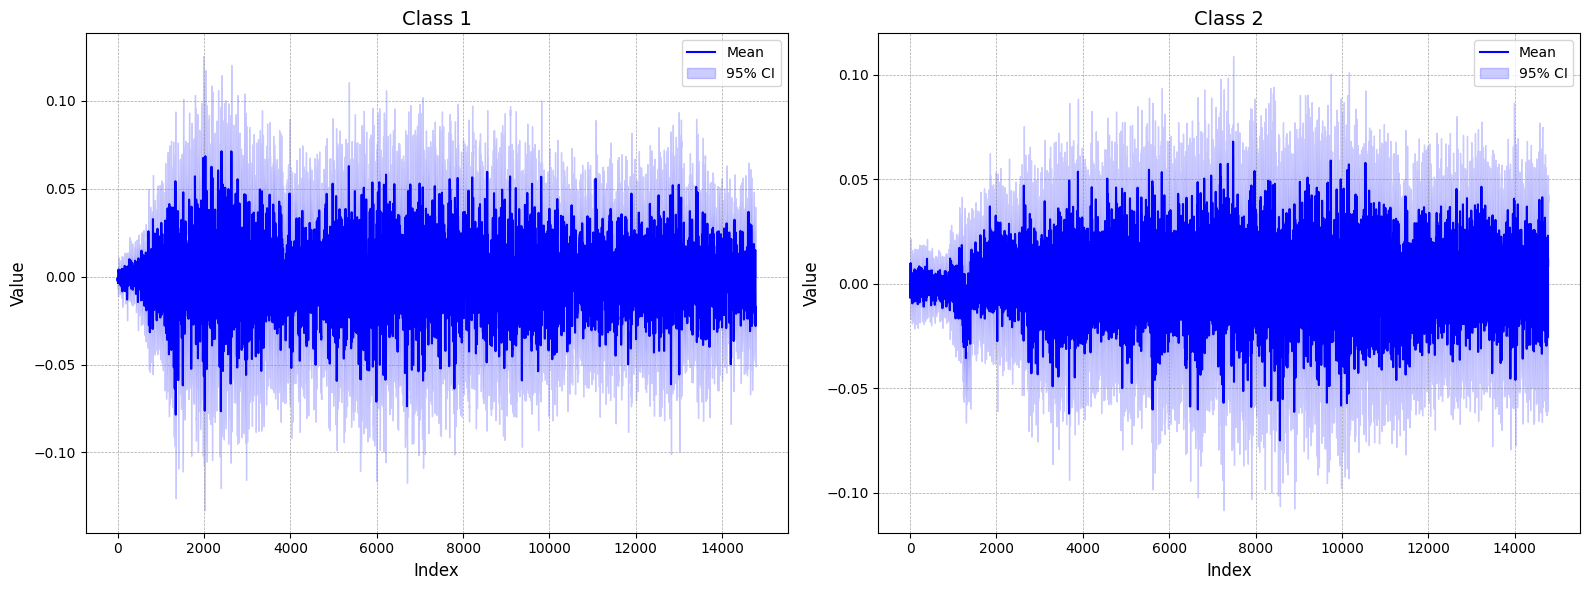

In [12]:
df0 = catsanddogs_X_train[catsanddogs_X_train["label"]==0].iloc[:, :-1]
df1 = catsanddogs_X_train[catsanddogs_X_train["label"]==1].iloc[:, :-1]
df_list = [df0, df1]
utils.plot_classes(df0, df1, num_seg=None)

Processing class 1...
Processing class 2...


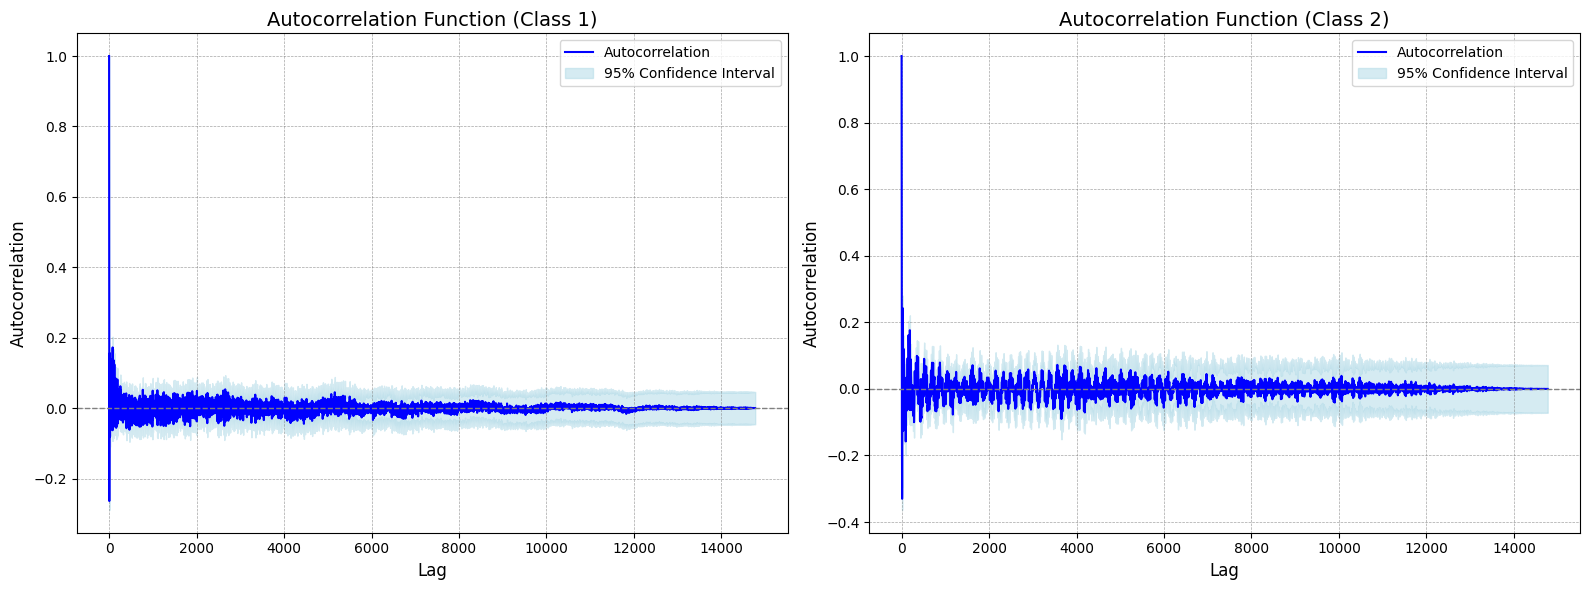

In [13]:
utils.plot_acf_mean_series(df_list)

Processing dataset 1...
Processing dataset 2...


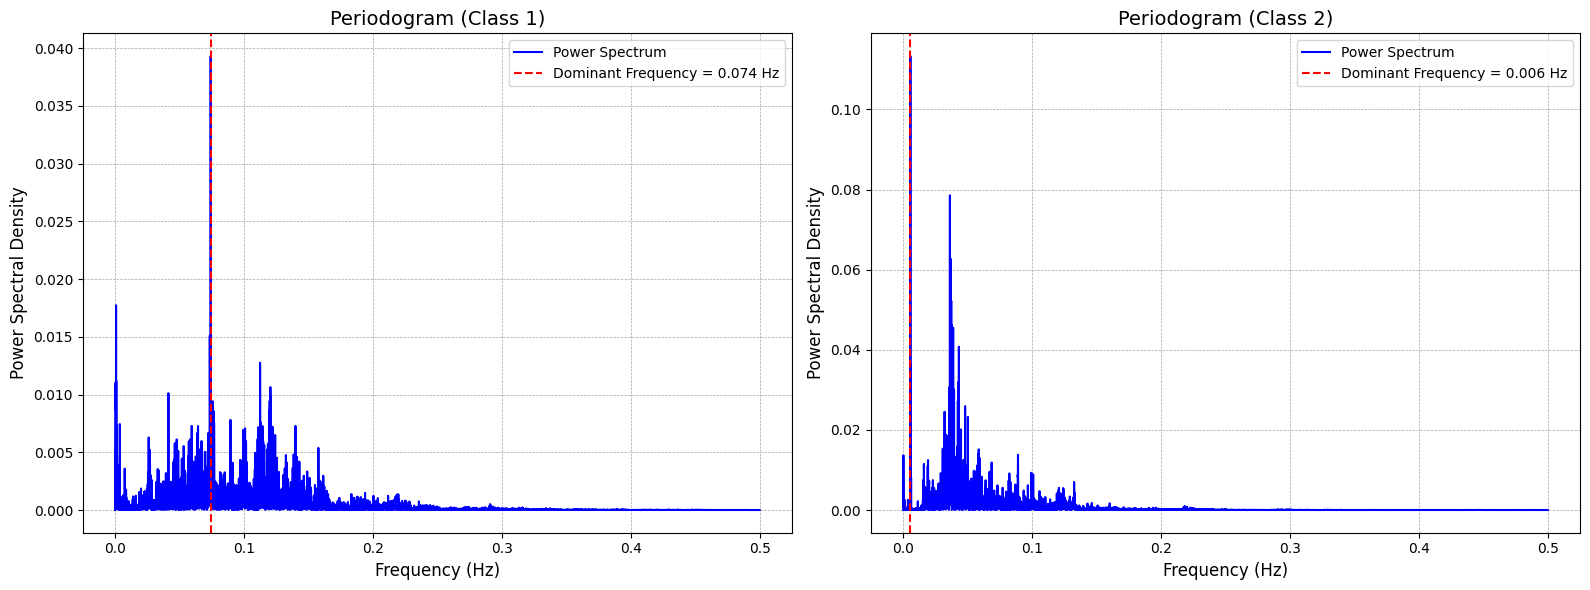

In [14]:
utils.plot_periodogram_mean_series(df_list)

# **Data Preprocessing - Why Does it Matters?**

In SAX methods, as we will see, the y-axis is "segmented" according to Gaussian breakpoints. This segmentation assumes and is more accurate when the distribution of time series values follows a law N(0, 1). To meet this assumption, it is important to center and scale the values of each time series.


In [16]:
ECG200_X_train_scaled, ECG200_X_test_scaled = utils.std_scaler(ECG200_X_train), utils.std_scaler(ECG200_X_test)
acsf1_X_train_scaled, acsf1_X_test_scaled = utils.std_scaler(acsf1_X_train), utils.std_scaler(acsf1_X_test)
catsanddogs_X_train_scaled, catsanddogs_X_test_scaled = utils.std_scaler(catsanddogs_X_train), utils.std_scaler(catsanddogs_X_test)

# **(SAX-based) Symbolization Methods Review and Reconstruction**

The SAX, ESAX, TSAX, and 1D-SAX methods rely on the PAA (Piecewise Aggregate Approximation) representation. This technique divides the time series into equal-sized segments, approximating the series in each segment with a constant value corresponding to the mean of the segment values. Once the PAA is obtained, the series values are assumed to follow a standard normal distribution. This assumption allows the value space to be divided into several intervals (or bins), defined so that each bin represents an equal area under the Gaussian density curve. In SAX, each bin is assigned a letter from the alphabet, and the series is then encoded by assigning to each segment the letter corresponding to the bin where its mean falls.  

The other three methods capture more information, often at the expense of data compression. For example, ESAX encodes the minimum and maximum values reached by the series within each segment, resulting in a word three times longer than SAX for the same number of segments and alphabet size. TSAX focuses on trends, while 1D-SAX encodes both the mean and the slope of the series in separate alphabets for each segment, combining these into unique symbols. Although this makes the method less effective for compression, it is more precise in terms of approximation.  

SFA and BOSS methods operate in the frequency domain. They analyze the characteristics of time series using the Discrete Fourier Transform (DFT) to capture relevant information about patterns and frequency distributions in the data. This approach enables better representation while reducing complexity, maintaining fidelity for tasks like classification, trend detection, or motif discovery. The most informative spectral components are selected at the database level, and a specific alphabet is associated with them.  

Finally, ASTRIDE introduces two key innovations: during the segmentation of the series and the creation of the alphabet. Its segmentation is adaptive, detecting change-points (often based on a mean criterion) at the database level. This means that the segmentation that makes the most sense across the entire dataset is retained. While it operates on the same principles as SAX, the bins associated with different letters are created based on the empirical quantiles of the means over each segment across the database. This makes ASTRIDE more data-sensitive than SAX for the same level of data compression.  

---

### **Summary Table of Key Features and Functions**  

| **Characteristic**              | **SAX**                              | **ESAX**                             | **TSAX**                              | **1D-SAX**                          | **ASTRIDE**                        | **SFA**                             | **BOSS**                            |
|-----------------------------------|---------------------------------------|---------------------------------------|----------------------------------------|--------------------------------------|-------------------------------------|--------------------------------------|--------------------------------------|
| **Segmentation**                 | Uniform                              | Uniform                              | Uniform                               | Uniform                             | Adaptive                           | Uniform                             | Sliding window                      |
| **Representation**               | Symbols via means                    | Symbols via means + min and max       | Symbols based on trends               | Symbols combining mean and slope    | Symbols via means                  | Symbols via frequency spectrum      | Histogram of SFA words over window |
| **Data Compression**             | High                                 | Medium                               | Medium                                | Low                                 | High                               | Medium                              | Medium                              |
| **Resistance to Variations**     | Low                                  | Medium                               | High                                  | Medium                              | High                               | Medium                              | Medium                              |
| **Reconstruction Fidelity**      | Low                                  | Medium                               | Low                                   | High                                | Low                                | Medium                              | Low                                 |
| **Specific Advantages**          | Simplicity and speed                 | Captures local trends                 | Focus on global direction             | Captures more detailed shapes       | Captures structured patterns       | Frequency analysis (robustness)    | Statistical analysis of words       |
| **Limitations**                  | Ignores trends and variations        | Increased complexity                  | Ignores exact values                  | Higher complexity                   | Strong dependence on patterns      | Requires FFT                        | Large histogram size                |

---


For a typical time series in each dataset, we will apply symbolization using each of these methods.

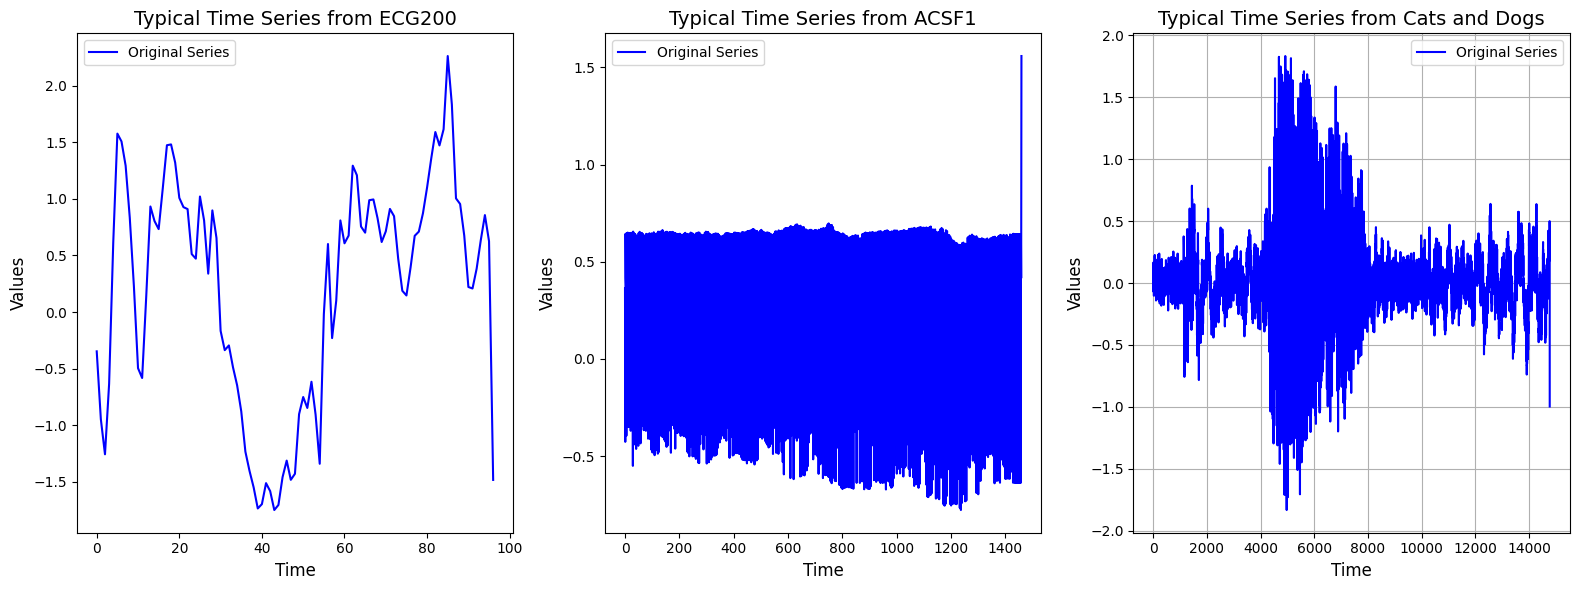

In [35]:
ECG200_ts = ECG200_X_train_scaled.iloc[0]
acsf1_ts = acsf1_X_train_scaled.iloc[0]
catsanddogs_ts = catsanddogs_X_train_scaled.iloc[0]

typical_ts = {
    "ECG200": ECG200_ts,
    "ACSF1": acsf1_ts,
    "Cats and Dogs": catsanddogs_ts
}

fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # Create 1x3 subplot layout
flat_axes = axes.flat  # Flatten axes for easy iteration

# Iterate through the dictionary items
for i, (method, ts) in enumerate(typical_ts.items()):
    ax = flat_axes[i]  # Select the current subplot

    # Plot the original time series
    ax.plot(np.array(ts), color='blue', label="Original Series")

    # Set title and axis labels
    ax.set_title(f"Typical Time Series from {method}", fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Values", fontsize=12)

    # Add legend
    ax.legend(loc='best', fontsize=10)

# Adjust spacing and show the plot
plt.tight_layout()
plt.grid(True)
plt.show()
    

## **Symbolic Aggregate approXimation**

We compare the SAX representation of the series for a segmentation of 10 or 20 and an alphabet size of 4 or 8.

In [26]:
sax_symb = {}
for method, ts in typical_ts.items(): 
    list = []
    print('******************')

    print(f"Method = {method}")
    SAX_1 = SAX_transform(np.array(ts), 10, 4)
    SAX_symb_1 = SAX_1.calculate_sax()
    print(f'The SAX version of the series is: {SAX_symb_1}, for 10 segments and 4 possible symbols')
    list.append((SAX_1,SAX_symb_1))
    SAX_2 = SAX_transform(np.array(ts), 20, 4)
    SAX_symb_2 = SAX_2.calculate_sax()
    print(f'The SAX version of the series is: {SAX_symb_2}, for 20 segments and 4 possible symbols')
    list.append((SAX_2,SAX_symb_2))
    SAX_3 = SAX_transform(np.array(ts), 10, 8)
    SAX_symb_3 = SAX_3.calculate_sax()
    print(f'The SAX version of the series is: {SAX_symb_3}, for 10 segments and 8 possible symbols')
    list.append((SAX_3,SAX_symb_3))
    SAX_4 = SAX_transform(np.array(ts), 20, 8)
    SAX_symb_4 = SAX_4.calculate_sax()
    print(f'The SAX version of the series is: {SAX_symb_4}, for 20 segments and 8 possible symbols')
    list.append((SAX_4,SAX_symb_4))

    sax_symb[method] = list
    print('******************')

******************
Method = ECG200
The SAX version of the series is: ccdbaacccc, for 10 segments and 4 possible symbols
The SAX version of the series is: adbcdcccaaaaaacdcccc, for 20 segments and 4 possible symbols
The SAX version of the series is: eegdaaefff, for 10 segments and 8 possible symbols
The SAX version of the series is: bgdfgffebaaaabegffef, for 20 segments and 8 possible symbols
******************
******************
Method = ACSF1
The SAX version of the series is: ccccccbbbb, for 10 segments and 4 possible symbols
The SAX version of the series is: cbcccccccccbbbcbbbbc, for 20 segments and 4 possible symbols
The SAX version of the series is: eeeeeedddd, for 10 segments and 8 possible symbols
The SAX version of the series is: edeeeeeeeeedddedddde, for 20 segments and 8 possible symbols
******************
******************
Method = Cats and Dogs
The SAX version of the series is: cbccbbcbcb, for 10 segments and 4 possible symbols
The SAX version of the series is: ccbbcbccbcbb

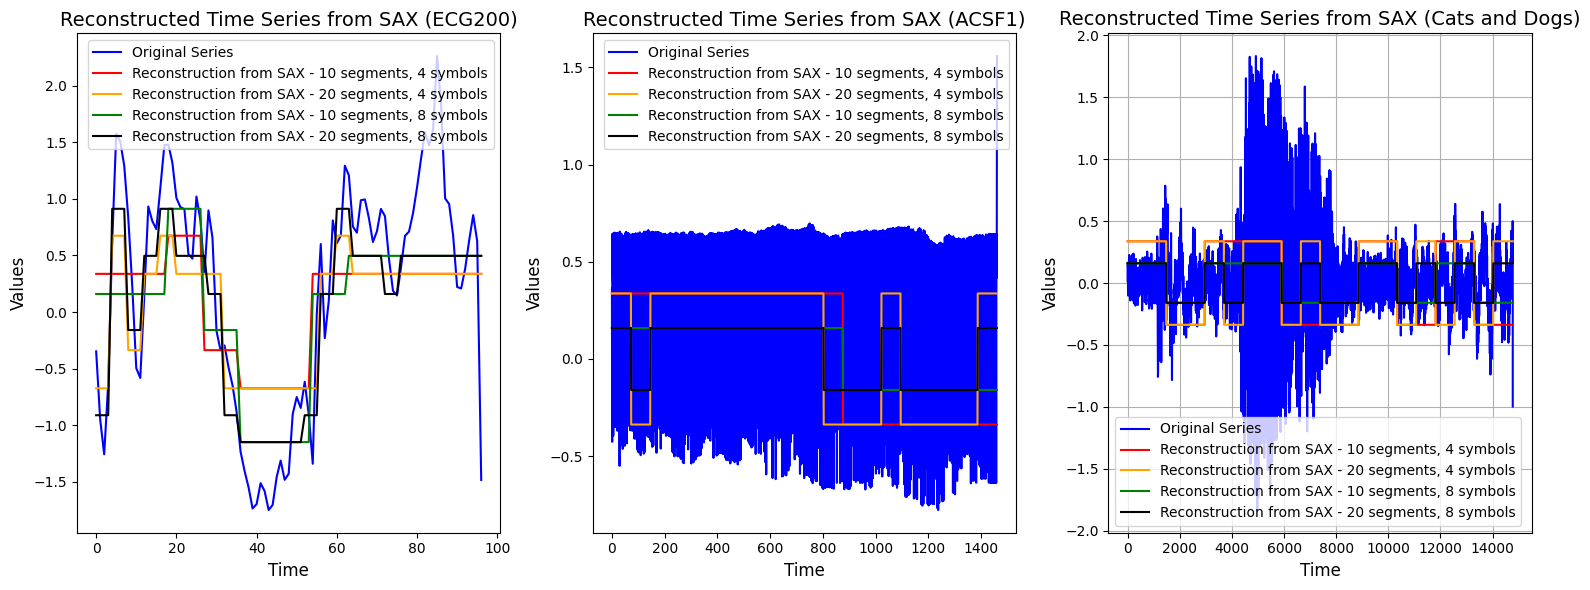

In [37]:
reconstruct_sax = {}
for method, SAX_symb in sax_symb.items():
    list = [SAX_symb_i[0].reconstruction_from_sax(SAX_symb_i[1]) for SAX_symb_i in SAX_symb]
    reconstruct_sax[method] = list

fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # Create 1x3 subplot layout
flat_axes = axes.flat  # Flatten axes for easy iteration

# Iterate through the dictionary items
for i, (method, ts) in enumerate(typical_ts.items()):
    ax = flat_axes[i]  # Select the current subplot

    # Plot the original time series
    ax.plot(np.array(ts), color='blue', label="Original Series")

    # Plot reconstructed series from SAX with various configurations
    ax.plot(reconstruct_sax[method][0], color='red', label="Reconstruction from SAX - 10 segments, 4 symbols")
    ax.plot(reconstruct_sax[method][1], color='orange', label="Reconstruction from SAX - 20 segments, 4 symbols")
    ax.plot(reconstruct_sax[method][2], color='green', label="Reconstruction from SAX - 10 segments, 8 symbols")
    ax.plot(reconstruct_sax[method][3], color='black', label="Reconstruction from SAX - 20 segments, 8 symbols")
    
    # Set title and axis labels
    ax.set_title(f"Reconstructed Time Series from SAX ({method})", fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Values", fontsize=12)

    # Add legend
    ax.legend(loc='best', fontsize=10)

# Adjust spacing and show the plot
plt.tight_layout()
plt.grid(True)
plt.show()


Obviously, when the time series is long, the approximation quickly becomes coarse with a small number of segments. We will now try to observe what happens for the long series Cats and Dogs as we increase the number of segments and symbols.


== interpréter davantage plot 1

In [1]:
large_CD_SAX = SAX_transform(np.array(catsanddogs_ts), 100, 20)
large_CD_SAX_symb = large_CD_SAX.calculate_sax()
large_CD_reconstruction = large_CD_SAX.reconstruction_from_sax(large_CD_SAX_symb)

fig, ax = plt.subplots(figsize=(16, 6))  # Create 1x3 subplot layout

# Plot the original time series
ax.plot(np.array(catsanddogs_ts), color='blue', label="Original C&D Series")

# Plot reconstructed series from SAX with various configurations
ax.plot(large_CD_reconstruction, color='red', label="Reconstruction from SAX - 100 segments, 20 symbols")

# Set title and axis labels
ax.set_title(f"Reconstructed Time Series from SAX (Cats and Dogs))", fontsize=14)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Values", fontsize=12)

# Add legend
ax.legend(loc='best', fontsize=10)

# Adjust spacing and show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

NameError: name 'SAX_transform' is not defined

This observation is very interesting as it highlights one of the main limitations of SAX. We observe that SAX performs a good reconstruction when clear and rapid trends are present, for example, for $t \geq 10000$. However, in areas where the amplitude is very strong but relatively stationary, SAX fails to achieve a good reconstruction because the movements are too fast, and no overall trend is observed. This is the case, for example, for $t \in [4500, 8000]$.

This finding reflects a bit of a trade-off with SAX: it is a very simple and easily implementable method at the cost of sometimes coarse approximations. We will see that this is one of the main limitations of this method, which has been addressed in other variants (1d-SAX, TSAX...) that include a notion of trend in the symbolic representation.


== dire qqch sur les rpz symboliques

## **Extended SAX** 

We do the same for ESAX ([reference](https://dl.acm.org/doi/10.1109/ICDEW.2006.99)), which encodes more information for each segment compared to SAX, namely the symbolic value of the minimum and maximum of the series on the segment. As a result, we notice that its symbolic representation compresses less information (3 times more symbols for the same number of segments). However, we can expect to observe better classification performance compared to SAX.

Regarding the reconstruction, it is not fundamentally different from SAX since knowing the minimum and maximum gives an idea of the range of the data on the segment, but it is not really useful for reconstruction.

We compare ESAX in the same way with several values of the parameters, namely the number of segments and the alphabet size.

In [ ]:
esax_symb = {}
for method, ts in typical_ts.items(): 
    list = []
    print('******************')

    print(f"Method = {method}")
    SAX_1 = SAX_transform(np.array(ts), 10, 4)
    SAX_symb_1 = SAX_1.calculate_esax()
    print(f'The ESAX version of the series is: {SAX_symb_1}, for 10 segments and 4 possible symbols')
    list.append((SAX_1,SAX_symb_1))
    SAX_2 = SAX_transform(np.array(ts), 20, 4)
    SAX_symb_2 = SAX_2.calculate_esax()
    print(f'The ESAX version of the series is: {SAX_symb_2}, for 20 segments and 4 possible symbols')
    list.append((SAX_2,SAX_symb_2))
    SAX_3 = SAX_transform(np.array(ts), 10, 8)
    SAX_symb_3 = SAX_3.calculate_esax()
    print(f'The ESAX version of the series is: {SAX_symb_3}, for 10 segments and 8 possible symbols')
    list.append((SAX_3,SAX_symb_3))
    SAX_4 = SAX_transform(np.array(ts), 20, 8)
    SAX_symb_4 = SAX_4.calculate_esax()
    print(f'The ESAX version of the series is: {SAX_symb_4}, for 20 segments and 8 possible symbols')
    list.append((SAX_4,SAX_symb_4))

    esax_symb[method] = list
    print('******************')

## **TSAX**

Trend-based Symbolic approximation (TSAX) represents each segment by four symbols ([reference](https://ieeexplore.ieee.org/document/8407498)). The first symbol cor- responds to the SAX representation. The following three symbols correspond to the slopes between the first, last, most peak and most dip points, which are defined in terms of vertical distance from the trend line (the straight line connecting the end point values of a segment). The slopes are converted to symbols using a lookup table. This results in a symbolic representation four times longer than the SAX representation with the same number of segments.

We fix the value of the angle alphabet to 5 and vary the segmentation size and the alphabet size for the means.


In [ ]:
tsax_symb = {}
for method, ts in typical_ts.items(): 
    list = []
    print('******************')

    print(f"Method = {method}")
    SAX_1 = SAX_transform(np.array(ts), 10, 4)
    SAX_symb_1 = SAX_1.calculate_tsax(5)
    print(f'The TSAX version of the series is: {SAX_symb_1}, for 10 segments and 4 possible symbols')
    list.append((SAX_1,SAX_symb_1))
    SAX_2 = SAX_transform(np.array(ts), 20, 4)
    SAX_symb_2 = SAX_2.calculate_tsax(5)
    print(f'The TSAX version of the series is: {SAX_symb_2}, for 20 segments and 4 possible symbols')
    list.append((SAX_2,SAX_symb_2))
    SAX_3 = SAX_transform(np.array(ts), 10, 8)
    SAX_symb_3 = SAX_3.calculate_tsax(5)
    print(f'The TSAX version of the series is: {SAX_symb_3}, for 10 segments and 8 possible symbols')
    list.append((SAX_3,SAX_symb_3))
    SAX_4 = SAX_transform(np.array(ts), 20, 8)
    SAX_symb_4 = SAX_4.calculate_tsax(5)
    print(f'The TSAX version of the series is: {SAX_symb_4}, for 20 segments and 8 possible symbols')
    list.append((SAX_4,SAX_symb_4))

    tsax_symb[method] = list
    print('******************')

## **1D-SAX**

On each segment, 1d-SAX ([reference](https://link.springer.com/chapter/10.1007/978-3-642-41398-8_24)) uniquely defines each association of two symbols encoding the mean and the slope of the linear regression of the series over time. To encode these two quantities, we use two distinct alphabets, which quickly increases the total alphabet size. From this unique encoding, we can perform the inverse operation and retrieve the mean value of the series as well as its slope on each segment, allowing us to reconstruct an approximation of the original series, piecewise linear.

In a manner similar to TSAX, we fix the length of the slope alphabet to 4, and we can vary the size of the segmentation and the alphabet.

In [ ]:
onedsax_symb = {}
for method, ts in typical_ts.items(): 
    list = []
    print('******************')

    print(f"Method = {method}")
    SAX_1 = SAX_transform(np.array(ts), 10, 4)
    SAX_symb_1 = SAX_1.transf_1d_sax(4, 4)
    print(f'The 1D-SAX version of the series is: {SAX_symb_1}, for 10 segments and 4 possible symbols')
    list.append((SAX_1,SAX_symb_1))
    SAX_2 = SAX_transform(np.array(ts), 20, 4)
    SAX_symb_2 = SAX_2.transf_1d_sax(4, 4)
    print(f'The 1D-SAX version of the series is: {SAX_symb_2}, for 10 segments and 4 possible symbols')
    list.append((SAX_2,SAX_symb_2))
    SAX_3 = SAX_transform(np.array(ts), 10, 8)
    SAX_symb_3 = SAX_3.transf_1d_sax(8, 4)
    print(f'The 1D-SAX version of the series is: {SAX_symb_3}, for 10 segments and 4 possible symbols')
    list.append((SAX_3,SAX_symb_3))
    SAX_4 = SAX_transform(np.array(ts), 20, 8)
    SAX_symb_4 = SAX_4.transf_1d_sax(8, 4)
    print(f'The 1D-SAX version of the series is: {SAX_symb_4}, for 10 segments and 4 possible symbols')
    list.append((SAX_4,SAX_symb_4))

    onedsax_symb[method] = list
    print('******************')

## **ASTRIDE**

## **Reconstruction Conclusion**

# **Classification** 

## **Nearest Neighbor Classification**

## **Sensitivity to Parameters**

## **Classification Conclusion**

# **Clustering**

## **Partitional Clustering**

## **Sensitivity to Parameters**

## **Clustering Conclusion**

# **Conclusion and Perspectives**